In [1]:
# Import libraries
from dynamita.sumo import *

import numpy as np
import time
import copy as cp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
%matplotlib notebook

In [3]:
# Specify path where Sumo is found and Sumo license
sumo = Sumo(sumoPath="C:/Users/Sara/AppData/Local/Dynamita/Sumo19",
           licenseFile=r"C:/Users/Sara/Desktop/sewerWRRF/networklicense.sumolic")

License OK...


To load and run a dynamic input:
1. Save the dynamic input(s) in a .tsv file.
  - To make this easy, you can first do it from the Sumo GUI. This will create a .tsv file in the project's temporary directory (View > Directories > Project Directory) and "loadtsv ..." will be logged in the Core Window.
2. Copy the new initialization script and dynamic influent .tsv file into the working folder.
3. Make sure the command "loadtsv ... xxx.tsv" is in the initialization script. 
  - If it is not there, find it in the Core Window and paste it into the initialization script (the one in the working folder). It shouldn't matter where it is in the script.
  - Make sure the .tsv file path is updated to the working folder.
  - This step can also be done via calls in Python: `command = 'loadtsv '+ TSV +' ;'` and `sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))` where `TSV` is the .tsv file.

In [4]:
# Unload any models and load Sumo model of interest
sumo.unload_model()
sumo.load_model('Sumo_Models/A2O plant_dynamic.sumo')

# Specify initialization script for Sumo model included above
sumo.core.csumo_command_send(sumo.handle, b'execute script_Initialize_A2O_dynamic.scs;')

# Write commands for pulling and storing Sumo variables based on variable positions
# Note that these variables will be initiated as empty lists (e.g., t_set = []) and populated throughout the simulation
def datacomm_callback(sumo):
    # Simulation time step
    t_set.append(sumo.core.csumo_var_get_time_double(sumo.handle))
    
    # Influent flow
    q_infl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, q_infl_pos))
    # Influent ammonia (SNHx) concentration
    snhx_infl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, snhx_infl_pos))
    # Influent total suspended solids (XTSS) concentration
    xtss_infl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, xtss_infl_pos))
    
    # Effluent flow
    q_effl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, q_effl_pos))
    # Effluent ammonia (SNHx) concentration
    snhx_effl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, snhx_effl_pos))
    # Effluent total suspended solids (XTSS) concentration
    xtss_effl_set.append(sumo.core.csumo_var_get_pvt_pos(sumo.handle, xtss_effl_pos))
    
    return 0

sumo.register_datacomm_callback(datacomm_callback)

# Write function for printing Sumo commands (e.g., initiating and running model simulations)
def message_callback(sumo):
    for message in sumo.messages:
        print(message)
    sumo.messages = []
    return 0

sumo.register_message_callback(message_callback)

# Specify the length of the simulation and the frequency at which variables will be reported
# These are provided in milliseconds
sumo.set_stopTime(16*24*60*60*1000)
sumo.set_dataComm(50*60*1000)

No model is loaded
530021 Set: Sumo__StopTime to 0
530021 Set: Sumo__DataComm to 3600000
530021 Set: Sumo__PlantName to C:\Users\DYNAMI~1\AppData\Local\Dynamita\Sumo18\TMP~1\xjzoiwqs.cba\SUMOPR~1.XML
530049 Core loop started.
530036 Script file script_Initialize_A2O_dynamic.scs loaded.
230001 Path set failed: ""
530020 Set mode: dynamic
530021 Set: Sumo__Plant__CSTR__param__L_V to 1000
530021 Set: Sumo__Plant__CSTR__param__Qair_N to 0
530021 Set: Sumo__Plant__CSTR2__param__L_V to 1500
530021 Set: Sumo__Plant__CSTR2__param__Qair_N to 0
530021 Set: Sumo__Plant__CSTR3__param__L_V to 4500
530021 Set: Sumo__Plant__Sideflowdivider__param__Qpumped_target to 72000
530030 TSV file "C:\Users\Sara\Desktop\sewerWRRF\SumoPythonPractice\Influent_Tables\Influent_Table1.tsv" loaded.
530021 Set: Sumo__StopTime to 1382400000
530021 Set: Sumo__DataComm to 3000000


In [5]:
# Store positions for variables of interest
q_infl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Influent__Q')
snhx_infl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Influent__SNHx')
xtss_infl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Influent__XTSS')

q_effl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Effluent__Q')
snhx_effl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Effluent__SNHx')
xtss_effl_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__Effluent__XTSS')

In [6]:
# Specify .tsv for reading the steady-state influent data
r_influentTSV = 'C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Tables/Influent_Table_step_base.tsv'

In [7]:
# Load changed .tsv file to Sumo
command = 'loadtsv '+ r_influentTSV +' ;'
sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))

1

530030 TSV file "C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Tables/Influent_Table_step_base.tsv" loaded.


In [8]:
# Initiate lists for variables to store
# These must correspond to those specified in 'datacomm_callback'
t_set = []
q_infl_set = []
snhx_infl_set = []
xtss_infl_set = []

q_effl_set = []
snhx_effl_set = []
xtss_effl_set = []

# Run Sumo model simulation
sumo.run_model()

# Sleep until the simulation is complete
while not sumo.simulation_finished:
    time.sleep(0.01)

530002 Simulation started.
530004 Simulation ended.


In [9]:
# Build dictionary to store variables
# Note '_base' denotes steady-state influent conditions
data_base = {}
data_base['t'] = t_set
data_base['q_infl'] = q_infl_set
data_base['snhx_infl'] = snhx_infl_set
data_base['xtss_infl'] = xtss_infl_set
data_base['q_effl'] = q_effl_set
data_base['snhx_effl'] = snhx_effl_set
data_base['xtss_effl'] = xtss_effl_set

# Build pandas dataframe to store variables dictionary
df_base = pd.DataFrame.from_dict(data_base)
# Set index in dataframe to the time (t) column
df_base.set_index('t')

,q_infl,snhx_infl,xtss_infl,q_effl,snhx_effl,xtss_effl
t,,,,,,
0.000000,24000.0,24.0,182.983467,23173.007614,1.000000,3324.747492
0.034722,24000.0,24.0,182.983467,23173.007614,0.836991,2587.804905
0.069444,24000.0,24.0,182.983467,23173.007614,0.700267,2014.695425
0.104167,24000.0,24.0,182.983467,23173.007614,0.624942,1569.007472
0.138889,24000.0,24.0,182.983467,23173.007614,0.567993,1222.416126
...,...,...,...,...,...,...
15.833333,24000.0,24.0,182.983467,23173.007614,0.471491,10.000001
15.868056,24000.0,24.0,182.983467,23173.007614,0.471460,10.000000
15.902778,24000.0,24.0,182.983467,23173.007614,0.471429,10.000000


### Change influent step value

In [10]:
# Specify .tsv for reading (r) diurnal influent data and writing (w) changes to a new file
r_influentTSV = 'C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Tables/Influent_Table_step_base.tsv'
w_influentTSV = 'C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Tables/Influent_Table_step.tsv'

# Read the original .tsv file as a pandas table
r_influentTSV_data = pd.read_table(r_influentTSV, sep='\t')

# Specify magnitude of step increases in influent flow
# Step increase will occur at (and continue after) simulation time step 9
# Steady-state (unchanged) is 24000 m^3/d
stepMags = [26000, 28000, 30000, 34000, 40000, 48000, 56000, 64000, 70000]

We are interested if step increases in influent flow scale linearly (or otherwise) to effluent variables (e.g., flow, SNHx concentration). We will initiate lists to see the response in influent flow, effluent flow, effluent SNHx concentration (e.g., q_infl_diff) with these step increases. These will be populated for each stepMags value with e.g.

max(df_small['q_infl'] - df_base['q_infl'])

where
- df_small['q_infl']: timeseries for influent flow with the step increase in influent
- df_base['q_infl']: timeseries for influent flow in the steady-state case
- df_small['q_infl'] - df_base['q_infl']: difference between these two timeseries and thus brings this down to zero
- max(df_small['q_infl'] - df_base['q_infl']): maximum of this difference since the step increase typically creates a peaked response

In [11]:
q_infl_diff = [0]
q_effl_diff = [0]
snhx_effl_diff = [0]

In [12]:
for j in stepMags:
    print('Step magnitude: ' + str(j) + '\n')
    
    # Make a change to the original .tsv file
    for i in range(9,16):
        r_influentTSV_data.loc[i]["Sumo__Plant__Influent__param__Q"] = j
        r_influentTSV_data
        
    # Write the changed .tsv file to a new file
    with open(w_influentTSV,'w') as write_tsv:
        write_tsv.write(r_influentTSV_data.to_csv(sep='\t', index=False))
    
    # Load changed .tsv file to Sumo
    command = 'loadtsv '+ w_influentTSV +' ;'
    sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
    
    # Rerun Sumo simulation
    t_set = []
    q_infl_set = []; snhx_infl_set = []; xtss_infl_set = []
    q_effl_set = []; snhx_effl_set = []; xtss_effl_set = []
    
    sumo.run_model()
    
    while not sumo.simulation_finished:
        time.sleep(0.01)
    
    # Unload changed .tsv file to Sumo
    command = 'unloadtsv '+ w_influentTSV +' ;'
    sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
    
    # Create dictionary of variables
    data_step = {}
    data_step['t'] = t_set
    data_step['q_infl'] = q_infl_set; data_step['snhx_infl'] = snhx_infl_set; data_step['xtss_infl'] = xtss_infl_set
    data_step['q_effl'] = q_effl_set; data_step['snhx_effl'] = snhx_effl_set; data_step['xtss_effl'] = xtss_effl_set
    
    # Create a pandas dataframe for this dictionary and index by time (t)
    df_step = pd.DataFrame.from_dict(data_step)
    df_step.set_index('t')
    
    # Append to the response lists
    q_infl_diff.append(max(df_step['q_infl'] - df_base['q_infl']))
    q_effl_diff.append(max(df_step['q_effl'] - df_base['q_effl']))
    snhx_effl_diff.append(max(df_step['snhx_effl'] - df_base['snhx_effl']))

Step magnitude: 26000

530030 TSV file "C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Tables/Influent_Table_step.tsv" loaded.
530002 Simulation started.
530004 Simulation ended.
530021 Set: Sumo__Plant__Influent__param__Q to 24000
530050 TSV file "C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Tables/Influent_Table_step.tsv" unloaded.
Step magnitude: 28000

530030 TSV file "C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Tables/Influent_Table_step.tsv" loaded.
530002 Simulation started.
530004 Simulation ended.Step magnitude: 30000


530021 Set: Sumo__Plant__Influent__param__Q to 24000
530050 TSV file "C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Tables/Influent_Table_step.tsv" unloaded.
530030 TSV file "C:/Users/Sara/Desktop/sewerWRRF/SumoPythonPractice/Influent_Tables/Influent_Table_step.tsv" loaded.
530002 Simulation started.
530004 Simulation ended.
530021 Set: Sumo__Plant__Influent__param__Q to 24000
Step magnitude: 34000
53005

<IPython.core.display.Javascript object>


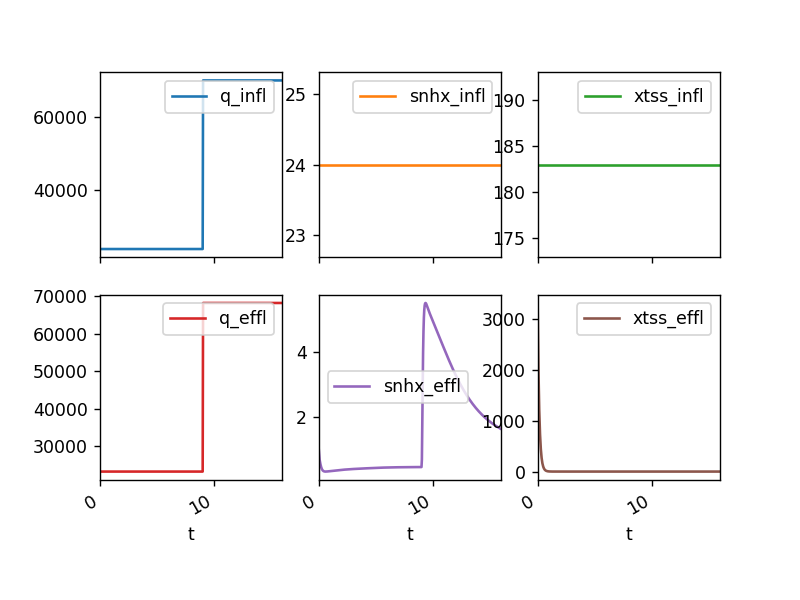

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x05B06A10>,
      dtype=object)

In [13]:
# Plot last step trial
df_step.plot(x = 't', kind='line', subplots='True', layout=(2,3))

<IPython.core.display.Javascript object>


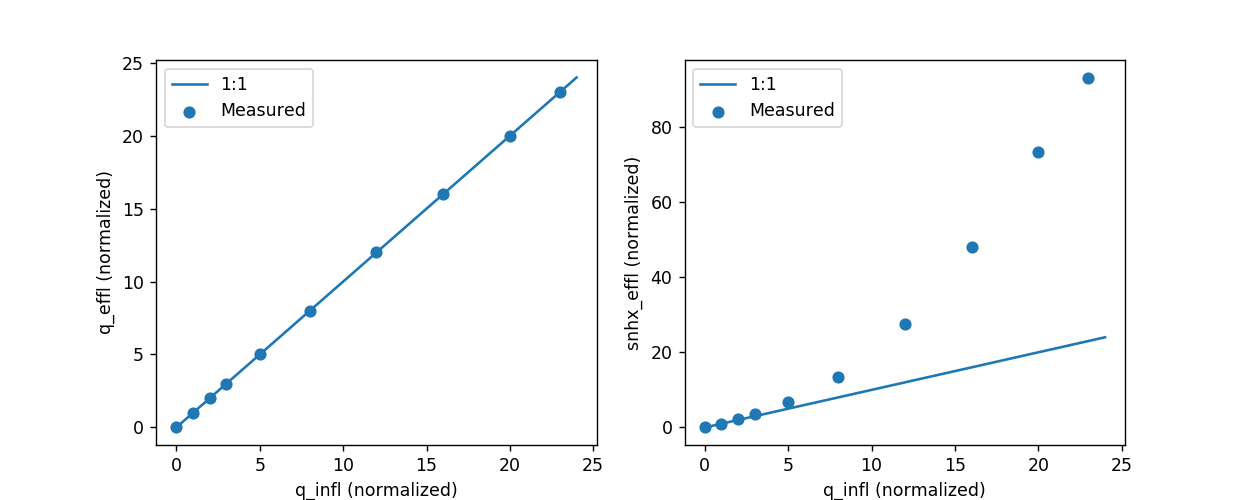

In [14]:
# Compare the step responses to the magnitude of step increases in influent flow
# Note we normalize to the entry in place 1 to be able to compare across scales of variables (e.g., flow v. SNHx concentration)
# The 1:1 line (based on place 1 entries) is also plotted for comparison
fig, axes = plt.subplots(1,2, figsize=(10,4))

axes[0].scatter(np.divide(q_infl_diff,q_infl_diff[1]), np.divide(q_effl_diff,q_effl_diff[1]), label="Measured")
axes[0].plot([0,24], [0,24], label="1:1")
axes[0].set_xlabel('q_infl (normalized)')
axes[0].set_ylabel('q_effl (normalized)')
axes[0].legend()

axes[1].scatter(np.divide(q_infl_diff,q_infl_diff[1]), np.divide(snhx_effl_diff,snhx_effl_diff[1]), label="Measured")
axes[1].plot([0,24], [0,24], label="1:1")
axes[1].set_xlabel('q_infl (normalized)')
axes[1].set_ylabel('snhx_effl (normalized)')
axes[1].legend()

It is clear that the SNHx effluent concentration does not scale linearly to step increases in influent flow. Instead, we try a quadratic relationship.

### Polynomial regression for relationship between influent flow and effluent SNHx concentration

In [15]:
# Import sklearn packages
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [16]:
# Initiate a 2-order polynomial
poly = PolynomialFeatures(degree = 2)
# Specify X as the normalized influent flow response and y as the normalized effluent SNHx concentration
X = np.divide(q_infl_diff,q_infl_diff[1]).reshape(-1, 1)
X_poly = poly.fit_transform(X)
y = np.divide(snhx_effl_diff,snhx_effl_diff[1]).reshape(-1, 1)

# Fit the polynomial
poly.fit(X_poly, y)
lin2 = LinearRegression()
lin2.fit(X_poly, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

<IPython.core.display.Javascript object>


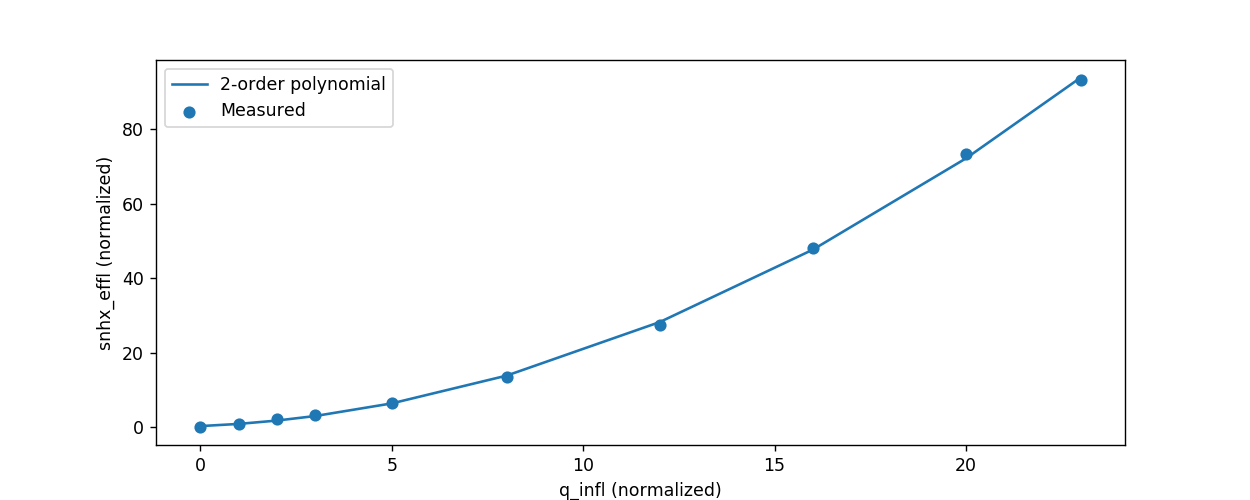

In [17]:
# Plot the measured and modeled (via 2-order polynomial) for comparison
fig, axes = plt.subplots(1,1, figsize=(10,4))

axes.scatter(X, y, label="Measured")
axes.plot(X, lin2.predict(poly.fit_transform(X)), label="2-order polynomial")
axes.set_xlabel('q_infl (normalized)')
axes.set_ylabel('snhx_effl (normalized)')
axes.legend()